# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [ ]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!rm -rf lab3
!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 26.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:05, 122MB/s] 
/content/lab3


In [ ]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
plt.rcParams["figure.figsize"] = (15.0, 5.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [ ]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding="utf-8") as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict


# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding="utf-8") as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict


# подсчет акустических признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None)
        mfcc = librosa.feature.mfcc(
            x, sr=sr, n_mfcc=13, n_fft=int(sr * 0.025), hop_length=int(sr * 0.01)
        )
        step += 1
        if count and step == count:
            print(f"Early stop at {step}th file..")
            break
        data_dict[wav_name.split(".")[0]] = mfcc.T
    return data_dict


phones_file = "data/train_librispeech_10h/phones"
phones_dict = load_phones_dict(phones_file)

ali_file = "data/train_librispeech_10h/ali_phones.txt"
ali_dict = load_phone_aligment(ali_file)

train_records_dir = "data/train_librispeech_10h/wav_dir"
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [ ]:
# объединение кадров признаков с соответствующими им фонемами:
def combine_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list) / sum(priors_list)


side_context = None
data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [ ]:
class CommonDataSet:
    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[: int((1 - valid_proportion) * len(data_list))]
        self.valid = data_list[int((1 - valid_proportion) * len(data_list)) :]
        self.device = device

    def num_batches(self, batch_size):
        return len(self.train) // batch_size

    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(
                self.train[i * batch_size : (i + 1) * batch_size, :-1],
                dtype=torch.float32,
            )
            batch_ys = torch.tensor(
                self.train[i * batch_size : (i + 1) * batch_size, -1].ravel(),
                dtype=torch.int64,
            )

            yield batch_xs.to(device), batch_ys.to(device)

In [ ]:
class MyNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim  # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim  # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
def train(model, dataset, batch_size, criterion, optimizer, loss_list, verbose=True):
    if verbose:
        start = time.time()
        print("TRAINING HAS STARTED...")

    for epoch in range(10):
        running_loss = 0
        counter = 0
        for batch_xs, batch_ys in tqdm(
            dataset.next_batch(batch_size),
            total=dataset.num_batches(batch_size),
            desc="Epoch {}".format(epoch),
            disable=not verbose,
        ):
            optimizer.zero_grad()
            output = model(batch_xs)

            loss = criterion(output, batch_ys)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            counter += 1

        if verbose:
            print("Loss: {:.4f}".format((running_loss / counter)))
        loss_list.append(running_loss / counter)

    if verbose:
        end = time.time()
        minutes = (end - start) // 60
        seconds = np.mod((end - start), 60)
        print("Training time: {} min {} sec".format(int(minutes), int(seconds)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256

# load data:
dataset = CommonDataSet(data_list, device)

net = MyNet(
    input_dim=(data_list[0].shape[0] - 1), output_dim=len(phones_dict.keys())
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

In [ ]:
# training network model:
train(net, dataset, batch_size, criterion, optimizer, loss_list)

TRAINING HAS STARTED...



Loss: 2.2851



Loss: 2.1633



Loss: 2.1266



Loss: 2.1027



Loss: 2.0841



Loss: 2.0684



Loss: 2.0548



Loss: 2.0425



Loss: 2.0313



Loss: 2.0210
Training time: 1 min 33 sec


In [ ]:
def plot_losses(loss_list):
    plt.plot(loss_list)
    plt.title("Loss per epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.show()

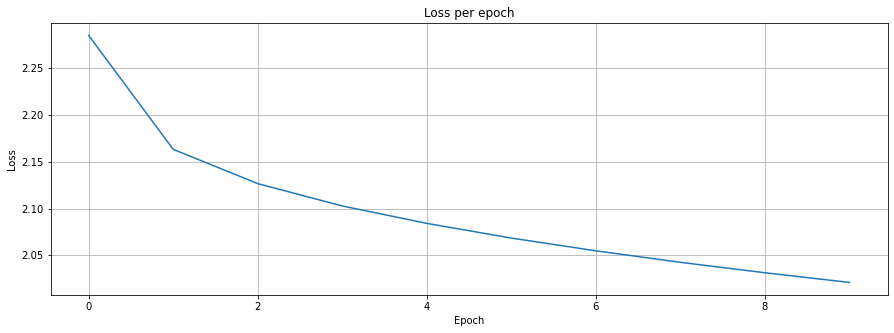

In [ ]:
plot_losses(loss_list)

In [ ]:
def evaluate(model, dataset, verbose=True):
    model.cpu()
    with torch.no_grad():
        correct_cnt = 0
        for ftr, true_label in tqdm(
            zip(dataset.valid[:, :-1], dataset.valid[:, -1]),
            total=dataset.valid.shape[0],
            disable=not verbose,
        ):
            ftr = torch.from_numpy(ftr).float()
            output = model(ftr)
            correct_cnt += output.argmax().item() == true_label

    total_frame_accuracy = correct_cnt / dataset.valid.shape[0]
    print("Total frame accuracy: {:.3f}.".format(total_frame_accuracy))

In [ ]:
evaluate(net, dataset, verbose=False)

Total frame accuracy: 0.430.


In [ ]:
def phonemes_accuracy(model, dataset, phones_dict):
    class_correct = [0 for x in range(len(phones_dict.keys()))]
    class_total = [0 for x in range(len(phones_dict.keys()))]
    model.cpu()
    with torch.no_grad():
        for ftr, true_label in tqdm(
            zip(dataset.valid[:, :-1], dataset.valid[:, -1]),
            total=dataset.valid.shape[0],
        ):
            ftr = torch.from_numpy(ftr).float()
            output = model(ftr)
            predict_label = output.argmax().item()

            class_correct[predict_label] += predict_label == int(true_label)
            class_total[int(true_label)] += 1

    for idx, phone in enumerate(phones_dict.keys()):
        if class_total[idx]:
            print(
                "{:3s}: {:.2f} : {}/{}".format(
                    phone,
                    class_correct[idx] / class_total[idx],
                    class_correct[idx],
                    class_total[idx],
                )
            )

In [ ]:
phonemes_accuracy(net, dataset, phones_dict)


SIL: 0.95 : 21532/22582
SPN: 0.01 : 3/570
AA0: 0.00 : 0/46
AA1: 0.26 : 475/1834
AA2: 0.03 : 3/96
AE0: 0.00 : 0/62
AE1: 0.48 : 1654/3416
AE2: 0.00 : 0/102
AH0: 0.27 : 1556/5665
AH1: 0.22 : 449/2022
AH2: 0.00 : 0/41
AO0: 0.00 : 0/24
AO1: 0.44 : 860/1972
AO2: 0.00 : 0/51
AW0: 0.00 : 0/6
AW1: 0.02 : 22/1052
AW2: 0.00 : 0/29
AY0: 0.00 : 0/43
AY1: 0.31 : 937/2979
AY2: 0.00 : 1/214
B  : 0.07 : 118/1624
CH : 0.08 : 67/870
D  : 0.19 : 745/4027
DH : 0.06 : 112/1984
EH0: 0.00 : 0/70
EH1: 0.23 : 668/2919
EH2: 0.00 : 0/98
ER0: 0.23 : 590/2563
ER1: 0.13 : 128/1017
ER2: 0.00 : 0/11
EY0: 0.00 : 0/23
EY1: 0.38 : 942/2496
EY2: 0.00 : 0/147
F  : 0.43 : 1044/2425
G  : 0.02 : 14/831
HH : 0.23 : 503/2163
IH0: 0.08 : 215/2716
IH1: 0.19 : 438/2355
IH2: 0.00 : 0/89
IY0: 0.27 : 577/2150
IY1: 0.64 : 1546/2413
IY2: 0.00 : 0/71
JH : 0.04 : 24/667
K  : 0.28 : 839/2969
L  : 0.57 : 2373/4168
M  : 0.33 : 1069/3284
N  : 0.55 : 3372/6107
NG : 0.10 : 134/1357
OW0: 0.00 : 0/182
OW1: 0.12 : 234/1943
OW2: 0.00 : 0/80
OY1: 

### Распознавание по словарю с помощью нейронки

In [ ]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding="utf-8") as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [ ]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]

    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)


class State:
    def __init__(self, model, index):
        self.model = model  # вектор признаков узла
        self.is_final = False  # является ли этот узел финальнвм в слове
        self.word = None  # слово эталона (назначается только для финального узла)
        self.best_token = None  # лучший токен (по минимуму дистанции) в узле
        self.current_word = None  # текущее слово эталона
        self.next_states = []  # список следующих узлов
        self.index = index  # индекс узла


def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [
        start_state,
    ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(
                AcousticModel(phone, phones_dict[phone], priors_list), state_index
            )
            state.current_word = (
                word  # слово эталона теперь будет храниться в каждом узле
            )
            state.next_states.append(state)  # add loop
            previous_state.next_states.append(state)
            previous_state = state
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [ ]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state  # стейт графа, в котором токен находится в текущий момент
        self.dist = dist  # общая накопленная дистанция пути, пройденного токеном
        self.word = word  # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[
        np.argmin([token.dist for token in alive_tokens if token.alive])
    ]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)):
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:
        index = token.state.index
        if graph[index].best_token:
            graph[index].best_token = None
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):
    start_state = graph[0]
    active_tokens = [
        Token(start_state),
    ]
    next_tokens = []

    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)
        next_tokens = beam_pruning(next_tokens, beam_threshold)

        active_tokens = next_tokens
        next_tokens = []

    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:
    record_word = filename.split("_")[0]
    etalon_word = win_token.state.word.split("_")[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [ ]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():
        recognition_results = recognize(
            filename,
            records_data_dict[filename],
            graph,
            nnet,
            recognition_results,
            beam_threshold,
        )

    wer = (1 - sum(recognition_results) / len(recognition_results)) * 100
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"WER: {wer:.2f}%")
    print(f"Total time: {total_time:.2f} sec")
    print("-" * 60)
    return wer, total_time

### Запустим распознавание на базе YES_NO

In [ ]:
lexicon_file = "data/lexicon_yes_no.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

wer_yn_no_context, time_yn_no_context = run_recognizer(
    records_data_dict, graph, net.cpu(), beam_threshold=100
)


result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
------------------------------------------------------------
WER: 0.00%
Total time: 1.85 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [ ]:
lexicon_file = "data/lexicon_digits.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

wer_digits_no_context, time_digits_no_context = run_recognizer(
    records_data_dict, graph, net.cpu(), beam_threshold=50
)


result: three_fce96bac_nohash_0     ==> ZERO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> ONE
result: two_fce65496_nohash_0       ==> TWO
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_ffbb695d_nohash_0      ==> FOUR
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: eight_da584bc0_nohash_4     ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: one_fc2411fe_nohash_0       ==> NINE
------------------------------------------------------------
WER: 15.00%
Total time: 15.57 sec
------

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на датасетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

In [ ]:
def make_windowed(data, side_context=0):
    """
    Expands each array value to the window of size (2 * side_context + 1).
    Uses edge padding.

    Example:
        >>> arr = np.asarray([1, 2, 3]).reshape(-1, 1)
        >>> print(arr)
        [[1]
         [2]
         [3]]
        >>> print(make_windowed(arr, side_context=1))
        [[1 1 2]
         [1 2 3]
         [2 3 3]]
    """
    # The data must be numpy array:
    data = np.pad(data, pad_width=((side_context, side_context), (0, 0)), mode="edge")

    data_list = []
    for frame in range(side_context, len(data) - side_context):
        frames = list(range(frame - side_context, frame + side_context + 1))
        data_list.append(np.concatenate([data[x] for x in frames]))

    return np.asarray(data_list)

In [ ]:
print("Original data_list shape:", data_list.shape)

Original data_list shape: (1282421, 14)


In [ ]:
# объединение кадров признаков с соответствующими им фонемами:
def combine_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]  # MFCC features for file frames
        file_feats = make_windowed(file_feats, side_context=side_context)
        file_ali = ali_dict[file_name]  # phonemes for file frames

        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1

    return data_list, np.array(priors_list) / max(sum(priors_list), 1)


side_context = 2
data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)
print("Windowed data_list shape:", data_list.shape)

Windowed data_list shape: (1282421, 66)


In [ ]:
# load data:
dataset = CommonDataSet(data_list, device)

net = MyNet(
    input_dim=(data_list[0].shape[0] - 1), output_dim=len(phones_dict.keys())
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

In [ ]:
train(net, dataset, batch_size, criterion, optimizer, loss_list)

TRAINING HAS STARTED...



Loss: 1.9592



Loss: 1.7274



Loss: 1.6494



Loss: 1.6000



Loss: 1.5637



Loss: 1.5348



Loss: 1.5107



Loss: 1.4899



Loss: 1.4715



Loss: 1.4550
Training time: 1 min 38 sec


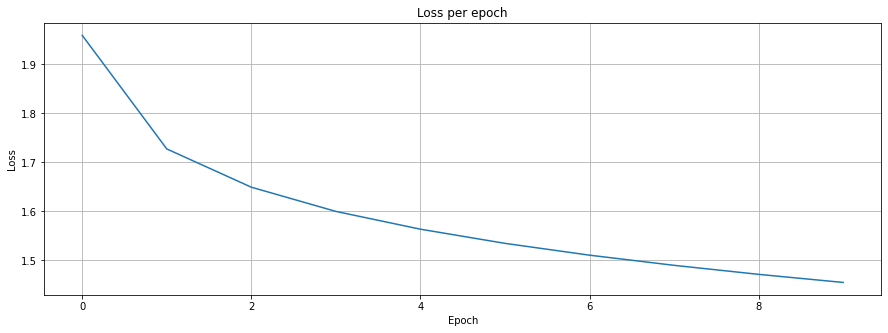

In [ ]:
plot_losses(loss_list)

In [ ]:
evaluate(net, dataset)


Total frame accuracy: 0.552.


In [ ]:
for side_context in [1, 2, 3, 4, 5]:
    data_list, priors_list = combine_data(
        ali_dict, feats_dict, phones_dict, side_context
    )
    data_list = np.random.permutation(data_list)

    dataset = CommonDataSet(data_list, device)

    net = MyNet(
        input_dim=(data_list[0].shape[0] - 1), output_dim=len(phones_dict.keys())
    ).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

    loss_list = []

    train(net, dataset, batch_size, criterion, optimizer, loss_list, verbose=False)

    print(f"Side context size: {side_context}.")
    evaluate(net, dataset, verbose=False)

Side context size: 1.
Total frame accuracy: 0.508.
Side context size: 2.
Total frame accuracy: 0.554.
Side context size: 3.
Total frame accuracy: 0.587.
Side context size: 4.
Total frame accuracy: 0.616.
Side context size: 5.
Total frame accuracy: 0.630.


In [ ]:
phonemes_accuracy(net, dataset, phones_dict)


SIL: 0.95 : 21318/22361
SPN: 0.01 : 4/564
AA0: 0.00 : 0/35
AA1: 0.45 : 832/1829
AA2: 0.00 : 0/77
AE0: 0.00 : 0/59
AE1: 0.66 : 2332/3522
AE2: 0.01 : 1/104
AH0: 0.47 : 2678/5695
AH1: 0.49 : 950/1932
AH2: 0.00 : 0/60
AO0: 0.00 : 0/19
AO1: 0.56 : 1172/2110
AO2: 0.00 : 0/47
AW0: 0.00 : 0/6
AW1: 0.45 : 466/1037
AW2: 0.07 : 2/28
AY0: 0.00 : 0/36
AY1: 0.70 : 2027/2900
AY2: 0.00 : 1/211
B  : 0.54 : 839/1562
CH : 0.42 : 358/862
D  : 0.42 : 1744/4135
DH : 0.58 : 1160/2017
EH0: 0.01 : 1/69
EH1: 0.38 : 1123/2941
EH2: 0.00 : 0/100
ER0: 0.41 : 1041/2534
ER1: 0.42 : 422/1015
ER2: 0.00 : 0/18
EY0: 0.00 : 0/16
EY1: 0.63 : 1568/2497
EY2: 0.01 : 1/119
F  : 0.74 : 1848/2496
G  : 0.36 : 313/875
HH : 0.59 : 1269/2151
IH0: 0.27 : 760/2846
IH1: 0.39 : 930/2368
IH2: 0.00 : 0/82
IY0: 0.38 : 841/2224
IY1: 0.63 : 1429/2273
IY2: 0.00 : 0/81
JH : 0.39 : 286/727
K  : 0.63 : 1877/2973
L  : 0.66 : 2786/4217
M  : 0.64 : 2023/3152
N  : 0.68 : 4181/6141
NG : 0.50 : 655/1309
OW0: 0.05 : 8/174
OW1: 0.51 : 1016/1974
OW2: 0.

In [ ]:
lexicon_file = "data/lexicon_yes_no.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

records_data_dict = {
    key: make_windowed(value, side_context=side_context)
    for key, value in records_data_dict.items()
}

wer_yn_context, time_yn_context = run_recognizer(
    records_data_dict, graph, net.cpu(), beam_threshold=100
)


result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
------------------------------------------------------------
WER: 0.00%
Total time: 1.67 sec
------------------------------------------------------------


In [ ]:
lexicon_file = "data/lexicon_digits.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

records_data_dict = {
    key: make_windowed(value, side_context=side_context)
    for key, value in records_data_dict.items()
}

wer_digits_context, time_digits_context = run_recognizer(
    records_data_dict, graph, net.cpu(), beam_threshold=50
)


result: three_fce96bac_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> ONE
result: two_fce65496_nohash_0       ==> TWO
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_ffbb695d_nohash_0      ==> FOUR
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: one_fc2411fe_nohash_0       ==> ONE
------------------------------------------------------------
WER: 5.00%
Total time: 13.53 sec
------

In [ ]:
print(f"WER for YES_NO improved by {wer_yn_no_context - wer_yn_context:.2f}%.")
print(
    f"Time for YES_NO increased by "
    f"{time_yn_context / time_yn_no_context:.1f} times."
)

print(f"WER for DIGITS improved by {wer_digits_no_context - wer_digits_context:.2f}%.")
print(
    f"Time for DIGITS increased by "
    f"{time_digits_context / time_digits_no_context:.1f} times."
)

WER for YES_NO improved by 0.00%.
Time for YES_NO increased by 0.9 times.
WER for DIGITS improved by 10.00%.
Time for DIGITS increased by 0.9 times.


Также можно отметить, что по мере увеличения размера окна контекста от 1 до 5 росла и точность классификации фонем.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [ ]:
class ListenerNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ListenerNet, self).__init__()
        # Layer sizes:
        n_nodes_hl1 = hidden_dim
        n_nodes_hl2 = hidden_dim
        n_nodes_hl3 = hidden_dim
        n_nodes_hl4 = hidden_dim
        # FC layers with ELU activations:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.a1 = nn.ELU()
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.a2 = nn.ELU()
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.a3 = nn.ELU()
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.a4 = nn.ELU()
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.a1(x)

        x = self.fc2(x)
        x = self.a2(x)

        x = self.fc3(x)
        x = self.a3(x)

        x = self.fc4(x)
        x = self.a4(x)

        x = self.fc5(x)
        return x

In [ ]:
data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context=5)
data_list = np.random.permutation(data_list)

dataset = CommonDataSet(data_list, device)

criterion = nn.CrossEntropyLoss()

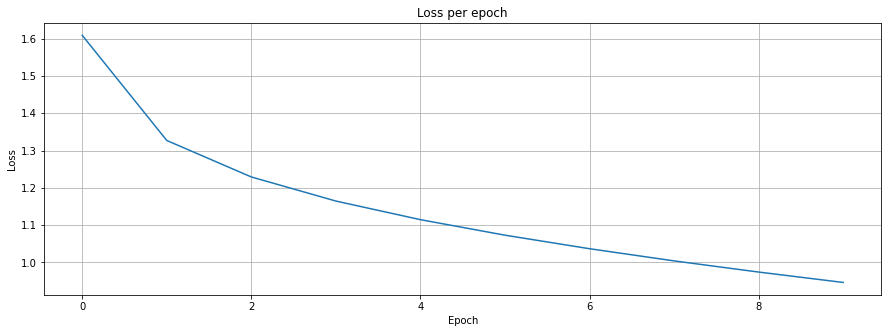

In [ ]:
net = ListenerNet(
    input_dim=(data_list[0].shape[0] - 1),
    hidden_dim=512,
    output_dim=len(phones_dict.keys()),
).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=5e-4)

loss_list = []

train(net, dataset, batch_size, criterion, optimizer, loss_list, verbose=False)
plot_losses(loss_list)

In [ ]:
evaluate(net, dataset)


Total frame accuracy: 0.669.


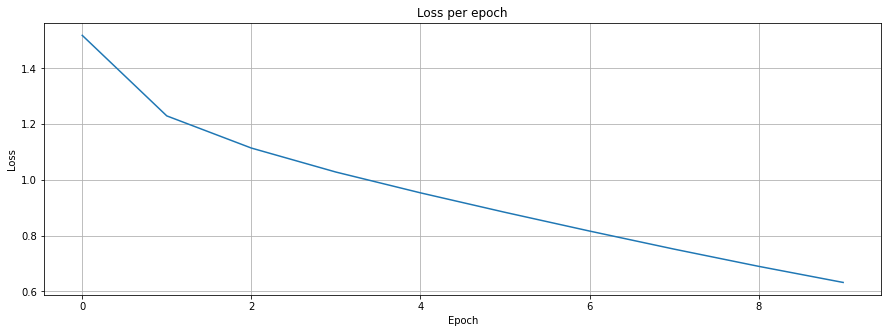

In [ ]:
net = ListenerNet(
    input_dim=(data_list[0].shape[0] - 1),
    hidden_dim=1024,
    output_dim=len(phones_dict.keys()),
).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=5e-4)

loss_list = []

train(net, dataset, batch_size, criterion, optimizer, loss_list, verbose=False)
plot_losses(loss_list)

In [ ]:
evaluate(net, dataset)


Total frame accuracy: 0.714.


Для экспериментов использовалось значение `side_context = 5`, поскольку по результатам предыдущего задания именно оно показало наилучшее качество классификации фонем.

Простое увеличение размеров скрытых слоёв с 256 до 512 дало прирост около 2-3% к качеству классификации, замена функции активации после скрытых слоёв с `ReLU` на `ELU` — ещё 1-2%, с итоговым значением точности порядка 66-67%.

Увеличение размеров скрытых слоёв до 1024 улучшило качество классификации ещё примерно на 4-5% (до 71-72%).